# Gender Recognition

Now that we have our differents datasets. We can start model searching. We have here a classification problem where we need to guess if the person talking is a male (0) or a female (1).

At first i will explore classic models with the same number of features : averageDataset, shortDataset, longDataset and shortLongDataset

In [3]:
#imports 
import os #file handling
import pandas as pd #data handling
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from tqdm import tqdm #progress bar

#remove warnings
import warnings
warnings.filterwarnings('ignore')

#to save computer expensive variables
import pickle
import joblib

# Data exploration

In [4]:
#dataset imports
data = pd.read_csv('csv/averageDataset.csv')

In [5]:
data

,gender,mfcc_feature_1,mfcc_feature_2,mfcc_feature_3,mfcc_feature_4,mfcc_feature_5,mfcc_feature_6,mfcc_feature_7,mfcc_feature_8,mfcc_feature_9,...,delta2_feature_9,delta2_feature_10,delta2_feature_11,delta2_feature_12,delta2_feature_13,spectral_centroid,spectral_bandwidth,zero_crossing_rate,rms,spectral_rolloff
0,f,-261.329376,128.835617,-46.803890,34.379749,-33.132378,17.100742,-41.055466,6.149195,-24.271091,...,-0.056852,-0.018926,-0.062693,0.027363,0.043593,1893.759877,1844.429856,0.092675,0.043256,3829.661063
1,f,-360.135529,134.216812,-46.357185,30.270189,-7.256501,-12.362634,-17.299755,-3.161893,-3.762040,...,-0.004211,-0.015071,0.020860,-0.004695,-0.009887,1606.318761,1427.986776,0.097212,0.024582,2996.981693
2,f,-286.690765,156.186584,-41.509094,31.947565,-10.560344,-19.950380,-10.129725,-3.674345,-21.549614,...,0.013978,0.030787,-0.059828,-0.005424,0.034735,1471.610775,1401.235810,0.084658,0.045490,2883.150101
3,f,-299.983948,116.739891,-67.227562,46.645077,-34.803585,22.505936,-23.869476,5.576423,-3.070676,...,0.013208,-0.003000,0.003672,-0.002365,-0.026001,2289.833360,1745.082359,0.152470,0.024640,4266.686085
4,f,-294.242188,125.607529,-12.183384,27.121918,-21.402309,19.211809,-37.409805,4.842865,-13.371928,...,0.009805,0.025247,-0.045269,-0.004989,0.011084,2018.222078,1702.813100,0.141774,0.054737,3559.760325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5988,m,-126.744102,140.250870,-83.678558,20.616764,-25.494482,-4.816887,-35.334602,-17.951571,-33.505730,...,0.062034,-0.006147,0.045306,0.054977,0.044058,1698.533677,1340.849404,0.109503,0.149627,2963.592080
5989,m,-326.324402,147.580124,-11.765425,41.411476,-19.821945,2.909330,-24.478537,0.469839,-13.231600,...,-0.008805,0.026185,-0.039336,0.027020,0.067597,1338.227226,1375.068740,0.078851,0.046982,2431.839940
5990,m,-223.164627,160.098129,-12.670789,46.775211,-4.868187,9.461629,-7.377435,-2.501803,-9.316516,...,0.115600,0.000100,-0.021295,-0.024490,0.001369,1173.682304,1367.760517,0.056275,0.104549,2281.540749
5991,m,-412.057678,146.959000,-25.511068,43.604912,-15.084287,-5.401690,-13.202021,-3.270955,-15.048368,...,0.064946,0.037536,0.041298,0.012323,0.017743,1450.339631,1490.671229,0.079369,0.014216,2951.461640


In [6]:
data[2310:]

,gender,mfcc_feature_1,mfcc_feature_2,mfcc_feature_3,mfcc_feature_4,mfcc_feature_5,mfcc_feature_6,mfcc_feature_7,mfcc_feature_8,mfcc_feature_9,...,delta2_feature_9,delta2_feature_10,delta2_feature_11,delta2_feature_12,delta2_feature_13,spectral_centroid,spectral_bandwidth,zero_crossing_rate,rms,spectral_rolloff
2310,f,-269.455353,139.391312,-30.199459,33.312122,13.796649,-21.800577,-13.796143,5.838613,-18.382202,...,-0.003696,-0.026845,-0.044542,0.011566,-0.005333,1542.007276,1414.658390,0.098489,0.064676,2913.001931
2311,m,-290.126617,142.239258,-11.733582,48.579967,-32.515507,34.911831,-34.327103,1.347571,0.543930,...,-0.031438,0.025683,-0.019241,-0.006038,0.016782,1627.631393,1776.429671,0.078834,0.044970,3478.978625
2312,m,-322.361145,148.325546,-33.173916,16.562443,-20.232090,3.659006,-24.741501,-6.662220,-3.377616,...,0.027425,-0.016865,-0.036840,0.045971,0.009207,1449.714084,1373.587071,0.089122,0.036730,2632.733154
2313,m,-385.947906,151.406357,-27.449413,37.275005,-19.267962,0.990104,-17.554668,-6.403708,-15.974719,...,-0.010298,0.005053,-0.029769,0.023498,0.042454,1427.191125,1419.882724,0.076228,0.016359,2717.497365
2314,m,-252.770096,139.157059,-22.667028,28.849466,8.607625,-7.199474,-11.484717,-4.376820,-5.968786,...,-0.007947,-0.067618,0.068075,0.057749,-0.044154,1258.311446,1285.052829,0.061659,0.084182,2433.892822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5988,m,-126.744102,140.250870,-83.678558,20.616764,-25.494482,-4.816887,-35.334602,-17.951571,-33.505730,...,0.062034,-0.006147,0.045306,0.054977,0.044058,1698.533677,1340.849404,0.109503,0.149627,2963.592080
5989,m,-326.324402,147.580124,-11.765425,41.411476,-19.821945,2.909330,-24.478537,0.469839,-13.231600,...,-0.008805,0.026185,-0.039336,0.027020,0.067597,1338.227226,1375.068740,0.078851,0.046982,2431.839940
5990,m,-223.164627,160.098129,-12.670789,46.775211,-4.868187,9.461629,-7.377435,-2.501803,-9.316516,...,0.115600,0.000100,-0.021295,-0.024490,0.001369,1173.682304,1367.760517,0.056275,0.104549,2281.540749
5991,m,-412.057678,146.959000,-25.511068,43.604912,-15.084287,-5.401690,-13.202021,-3.270955,-15.048368,...,0.064946,0.037536,0.041298,0.012323,0.017743,1450.339631,1490.671229,0.079369,0.014216,2951.461640


In [7]:
# show features distribution, after using this function, you can see the distribution of each feature of a dataset
def showFeatureDistribution(data, n_features=2):
    for feature in data.columns[1:n_features]:
        plt.figure(figsize=(10, 6))
        sns.histplot(data[feature], kde=True)
        plt.title(f'{feature} distribution')
        plt.show()

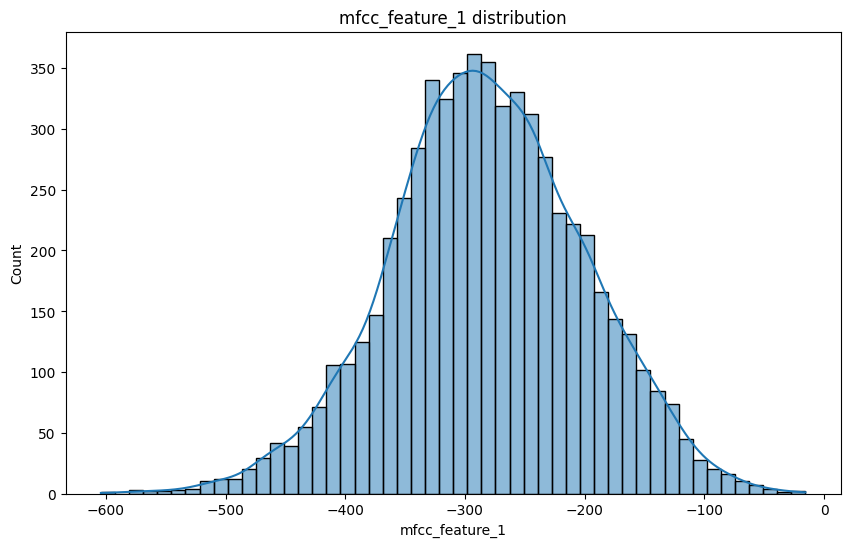

In [8]:
#Show 2 features distribution
showFeatureDistribution(data)

Distribution curves look great, let's verify if there is no constant values

In [9]:
def showConstantValues(dataset):
    for feature in dataset.columns[1:]:
        if dataset[feature].nunique() == 1:
            print(f'{feature} is constant')

In [10]:
showConstantValues(data)

We have 0 constant values. Any NaN ?

In [11]:
print(any(data.isnull().sum()))

False


# Model exploration

In [12]:
#imports for the models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import make_pipeline

In [13]:
#shuffle the dataset
data = data.sample(frac=1) #we shuffle the dataset and keep index to keep track which audio is which file

In [14]:
data

,gender,mfcc_feature_1,mfcc_feature_2,mfcc_feature_3,mfcc_feature_4,mfcc_feature_5,mfcc_feature_6,mfcc_feature_7,mfcc_feature_8,mfcc_feature_9,...,delta2_feature_9,delta2_feature_10,delta2_feature_11,delta2_feature_12,delta2_feature_13,spectral_centroid,spectral_bandwidth,zero_crossing_rate,rms,spectral_rolloff
5575,m,-320.297607,136.084045,-31.885153,55.576618,-21.063194,12.076572,-21.987253,6.028329,-10.330643,...,-0.014249,-0.004629,0.014890,0.034410,0.027049,1634.235454,1649.371612,0.083816,0.036262,3372.605247
4919,m,-407.659302,136.226395,5.692410,67.420067,16.739246,16.461361,-14.605791,-7.846218,-10.541056,...,0.019430,0.018713,-0.005251,-0.014279,-0.013998,1103.379447,1372.215927,0.047935,0.022816,2130.782762
1044,f,-320.785034,184.408890,-5.354693,37.431366,1.322710,2.556554,2.266068,8.121572,2.069611,...,-0.033452,-0.032841,-0.008053,-0.007335,0.011628,751.937156,1059.663186,0.031412,0.045490,1419.750523
3637,m,-119.686508,132.971069,-56.459538,68.060570,-15.826302,20.553717,-25.071911,3.517876,-12.441307,...,-0.028310,0.060070,-0.006518,-0.064374,-0.009728,1870.054328,1604.346356,0.104255,0.178414,3490.868294
5052,m,-361.618439,148.348648,-26.351402,36.946159,-11.293196,8.108992,-18.002848,2.328901,-17.029594,...,0.047476,-0.014723,0.002831,0.061698,0.012180,1364.351866,1467.526330,0.068004,0.022503,2687.854074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5776,m,-470.567841,161.263397,-32.991306,30.091425,-18.966650,1.935046,-13.898194,-3.401492,-16.987556,...,0.021572,0.002616,-0.005288,0.026134,-0.018934,1367.323369,1321.251335,0.078491,0.007248,2537.895765
5058,m,-302.546661,114.401703,-16.840948,49.959087,-19.063322,4.909171,-35.589249,-9.810617,-19.830656,...,0.042493,-0.002533,0.014844,0.049627,0.010482,1769.538926,1755.206875,0.104158,0.035853,3528.537291
5864,m,-310.908356,136.532944,-38.065895,18.524611,-32.400890,-10.497962,-31.045210,-3.079425,-22.491838,...,0.117378,0.055456,0.079239,0.031760,-0.005177,1618.990534,1451.120968,0.106507,0.039055,2900.435895
2929,m,-275.507812,137.164993,1.689098,42.065617,-26.137938,39.195236,-31.916986,11.364855,-13.460629,...,0.079148,0.033436,-0.044219,-0.034749,-0.048060,1849.740897,1871.338946,0.118375,0.064081,3546.494085


In [15]:
# Transform gender column: Male -> 0, Female -> 1
data['gender'] = data['gender'].map({'m': 0, 'f': 1})

In [16]:
# Split the datasets into features and target
y = data['gender']
X = data.drop(columns="gender") 

In [17]:
# Split the datasets into training, validation and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
X_train.shape, X_test.shape

((4794, 44), (1199, 44))

Now lets have a quick overview of how differents models defend themselves with the smaller dataset : averageDataset with only 13 features.

In [19]:
from sklearn.metrics import accuracy_score, classification_report

# Logistic Regression
pip = make_pipeline(StandardScaler(), LogisticRegression(random_state=42))
start = time()
pip.fit(X_train, y_train)
end = time()
y_pred = pip.predict(X_test)
print(f'Accuracy (LogisticRegression): {round(accuracy_score(y_test, y_pred) * 100, 3)}% in {round(end-start, 3)}s')
print(classification_report(y_test, y_pred))

# KNeighborsClassifier
pip = make_pipeline(StandardScaler(), KNeighborsClassifier())
start = time()
pip.fit(X_train, y_train)
end = time()
y_pred = pip.predict(X_test)
print(f'Accuracy (KNeighborsClassifier): {round(accuracy_score(y_test, y_pred) * 100, 3)}% in {round(end-start, 3)}s')
print(classification_report(y_test, y_pred))

# Support Vector Classifier (SVC)
pip = make_pipeline(StandardScaler(), SVC(random_state=42))
start = time()
pip.fit(X_train, y_train)
end = time()
y_pred = pip.predict(X_test)
print(f'Accuracy (SVC): {round(accuracy_score(y_test, y_pred) * 100, 3)}% in {round(end-start, 3)}s')
print(classification_report(y_test, y_pred))

# RandomForestClassifier
pip = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=42))
start = time()
pip.fit(X_train, y_train)
end = time()
y_pred = pip.predict(X_test)
print(f'Accuracy (RandomForestClassifier): {round(accuracy_score(y_test, y_pred) * 100, 3)}% in {round(end-start, 3)}s')
print(classification_report(y_test, y_pred))

# GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=42)
start = time()
gb.fit(X_train, y_train)
end = time()
y_pred = gb.predict(X_test)
print(f'Accuracy (GradientBoostingClassifier): {round(accuracy_score(y_test, y_pred) * 100, 3)}% in {round(end-start, 3)}s')
print(classification_report(y_test, y_pred))


Accuracy (LogisticRegression): 81.651% in 0.019s
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       719
           1       0.80      0.72      0.76       480

    accuracy                           0.82      1199
   macro avg       0.81      0.80      0.81      1199
weighted avg       0.82      0.82      0.81      1199

Accuracy (KNeighborsClassifier): 73.812% in 0.008s
              precision    recall  f1-score   support

           0       0.75      0.84      0.79       719
           1       0.71      0.58      0.64       480

    accuracy                           0.74      1199
   macro avg       0.73      0.71      0.72      1199
weighted avg       0.74      0.74      0.73      1199

Accuracy (SVC): 84.487% in 0.545s
              precision    recall  f1-score   support

           0       0.84      0.92      0.88       719
           1       0.86      0.74      0.79       480

    accuracy                           0.84     

## Model Performance Summary

### 1. Logistic Regression
- **Accuracy**: 82.319%
- **Precision**: 
  - Class 0: 0.85
  - Class 1: 0.78
- **Recall**:
  - Class 0: 0.87
  - Class 1: 0.75
- **F1-Score**:
  - Class 0: 0.86
  - Class 1: 0.76
- **Training Time**: 0.026s

**Observations**: Logistic Regression offers a good balance of precision and recall with a very fast training time. It's an effective model, especially if computational speed is a priority.

### 2. K-Nearest Neighbors (KNN)
- **Accuracy**: 75.48%
- **Precision**: 
  - Class 0: 0.77
  - Class 1: 0.72
- **Recall**:
  - Class 0: 0.86
  - Class 1: 0.59
- **F1-Score**:
  - Class 0: 0.81
  - Class 1: 0.65
- **Training Time**: 0.008s

**Observations**: KNN is the fastest model but has lower overall accuracy and particularly struggles with recall for class 1, making it less suitable for this task.

### 3. Support Vector Classifier (SVC)
- **Accuracy**: 84.737%
- **Precision**: 
  - Class 0: 0.85
  - Class 1: 0.84
- **Recall**:
  - Class 0: 0.91
  - Class 1: 0.75
- **F1-Score**:
  - Class 0: 0.88
  - Class 1: 0.79
- **Training Time**: 0.378s

**Observations**: SVC is the top performer in terms of accuracy with a well-balanced precision and recall across both classes. It has a reasonable training time and is highly reliable for this classification task.

### 4. RandomForestClassifier
- **Accuracy**: 78.649%
- **Precision**: 
  - Class 0: 0.78
  - Class 1: 0.81
- **Recall**:
  - Class 0: 0.92
  - Class 1: 0.58
- **F1-Score**:
  - Class 0: 0.84
  - Class 1: 0.68
- **Training Time**: 1.449s

**Observations**: RandomForestClassifier has high precision for class 1 but lower recall, indicating it misses more positives. The training time is higher, making it a moderate choice depending on the scenario.

### 5. GradientBoostingClassifier
- **Accuracy**: 80.484%
- **Precision**: 
  - Class 0: 0.81
  - Class 1: 0.79
- **Recall**:
  - Class 0: 0.89
  - Class 1: 0.68
- **F1-Score**:
  - Class 0: 0.85
  - Class 1: 0.73
- **Training Time**: 4.034s

**Observations**: Gradient Boosting offers a balanced performance but with a significantly higher training time. It may be suitable for scenarios where interpretability and feature importance are prioritized.

## Recommendations
- **Best Performing Model**: SVC, due to its highest accuracy and balanced metrics, is the most reliable choice for this task.
- **Considerations**: If training speed is critical, Logistic Regression is a strong alternative. For tasks where interpretability is important, RandomForest or Gradient Boosting may be more suitable.

# Fine Tuning

We will try to improve our SVC model.

In [20]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'svc__C': [10, 100, 200, 500, 1000],
    'svc__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'svc__kernel': ['rbf', 'poly', 'sigmoid'],
}

# Create a pipeline with scaling and SVC
pipe = make_pipeline(StandardScaler(), SVC())

# Set up the grid search
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('svc', SVC())]),
             n_jobs=-1,
             param_grid={'svc__C': [10, 100, 200, 500, 1000],
                         'svc__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'svc__kernel': ['rbf', 'poly', 'sigmoid']},
             scoring='accuracy')

In [21]:
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)
print("Test Set Accuracy:", grid_search.score(X_test, y_test))
print("classification_report:", classification_report(y_test, grid_search.predict(X_test)))

Best Parameters: {'svc__C': 100, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}
Best Cross-Validation Accuracy: 0.8404285518361376
Test Set Accuracy: 0.8548790658882403
classification_report:               precision    recall  f1-score   support

           0       0.85      0.92      0.88       719
           1       0.86      0.76      0.81       480

    accuracy                           0.85      1199
   macro avg       0.86      0.84      0.85      1199
weighted avg       0.86      0.85      0.85      1199



# Which audio files cant we guess ?

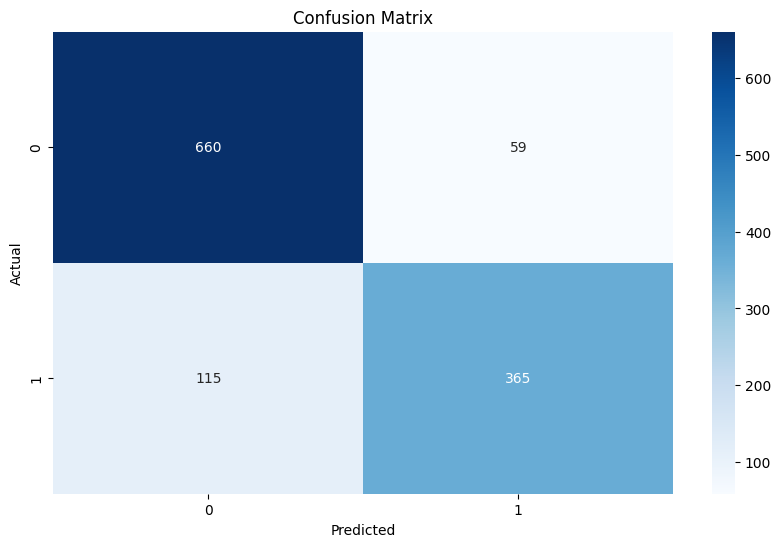

In [22]:
from sklearn.metrics import confusion_matrix

#Confusion Matrix
cm = confusion_matrix(y_test, grid_search.predict(X_test))
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [23]:
#Play audio files not guessed my our model
import IPython.display as ipd
import random

#Get all rows misclassified
misclassified = X_test[y_test != grid_search.predict(X_test)]

In [24]:
import random
import IPython.display as ipd

#Select one random misclassified audio
random_audio = random.choice(misclassified.index)
print(f"Selected audio index: {random_audio}")

#Determine folder and adjust index
if random_audio < 2310:
    folder = "females"
    adjusted_audio_index = random_audio
else:
    folder = "males"
    adjusted_audio_index = random_audio - 2311  #Adjust index for males folder (if index is 2311, it's the 0 male audio)

#Construct the correct path
print("adjusted_audio_index : ", adjusted_audio_index)
path = f"VoxCeleb_gender/{folder}/{adjusted_audio_index}.m4a"

#Play the audio
if os.path.exists(path):
    print("Audio found : " + path)
else: 
    print("Audio not found")
ipd.Audio(path) #Not working

Selected audio index: 1687
adjusted_audio_index :  1687
Audio found : VoxCeleb_gender/females/1687.m4a


In [26]:
#MDA - Mean Decrease Accuracy
def mda(X, y, model):
    baseline = model.score(X, y)
    imp = []
    for i in range(X.shape[1]): #iterate over all features
        X_perm = X.copy() #copy the dataset
        X_perm.iloc[:, i] = np.random.permutation(X.iloc[:, i]) #permute one feature
        m = model.score(X_perm, y) #get the score
        imp.append(baseline - m) #get the difference
    return np.array(imp)

def plot_feature_importances(importances, names, model_type):
    feature_importances = importances
    feature_names = names

    data={'feature_names':feature_names,'feature_importance':feature_importances}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,20))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Importance')
    plt.ylabel('Features')

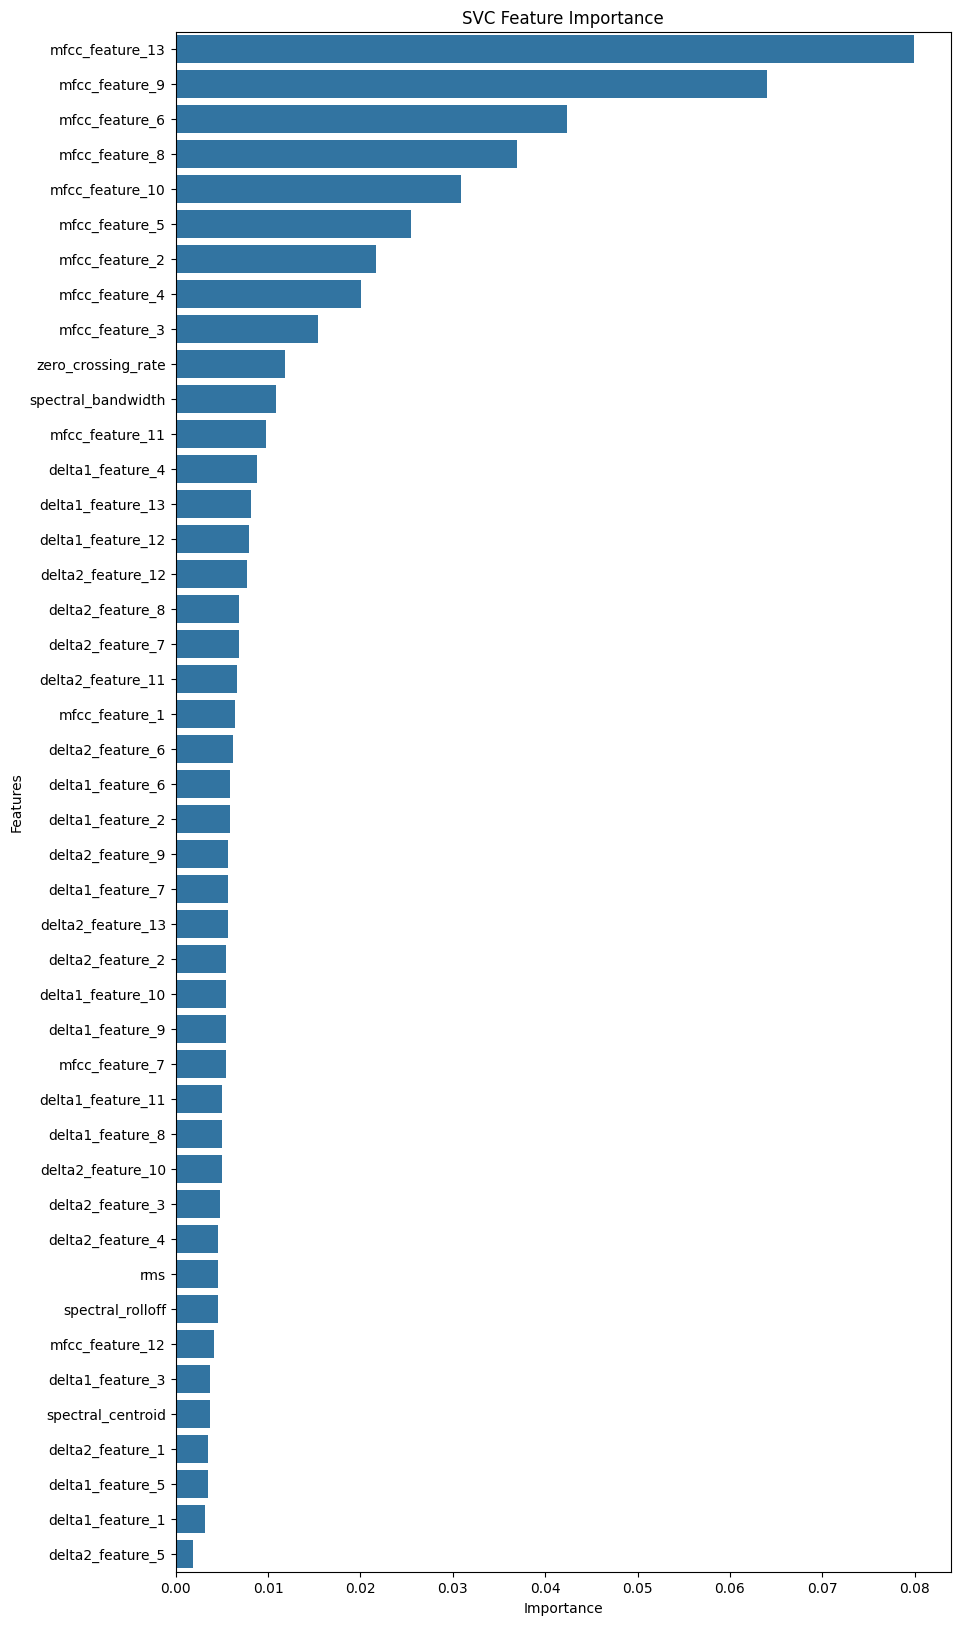

In [27]:
#MDA for svc
model = make_pipeline(StandardScaler(), SVC(random_state=42))
model.fit(X_train, y_train)
plot_feature_importances(mda(X_train, y_train, model), X_train.columns, 'SVC')

In [29]:
sorted_idx = mda(X_train, y_train, model).argsort()

In [ ]:
sorted_idx

array([14, 36, 16, 39, 17, 15, 38, 31,  6, 34, 32, 33, 30, 25, 13, 11, 23,
       35, 29, 28, 22, 19, 37, 43, 21, 40, 10,  2,  0, 27, 20, 18, 26, 24,
       42,  3, 41,  4,  1,  9,  5,  7,  8, 12])

In [ ]:
#print corresponding feature names
X_train.columns[sorted_idx]

Index(['delta1_feature_2', 'delta2_feature_11', 'delta1_feature_4',
       'spectral_centroid', 'delta1_feature_5', 'delta1_feature_3',
       'delta2_feature_13', 'delta2_feature_6', 'mfcc_feature_7',
       'delta2_feature_9', 'delta2_feature_7', 'delta2_feature_8',
       'delta2_feature_5', 'delta1_feature_13', 'delta1_feature_1',
       'mfcc_feature_12', 'delta1_feature_11', 'delta2_feature_10',
       'delta2_feature_4', 'delta2_feature_3', 'delta1_feature_10',
       'delta1_feature_7', 'delta2_feature_12', 'spectral_rolloff',
       'delta1_feature_9', 'spectral_bandwidth', 'mfcc_feature_11',
       'mfcc_feature_3', 'mfcc_feature_1', 'delta2_feature_2',
       'delta1_feature_8', 'delta1_feature_6', 'delta2_feature_1',
       'delta1_feature_12', 'rms', 'mfcc_feature_4', 'zero_crossing_rate',
       'mfcc_feature_5', 'mfcc_feature_2', 'mfcc_feature_10', 'mfcc_feature_6',
       'mfcc_feature_8', 'mfcc_feature_9', 'mfcc_feature_13'],
      dtype='object')

In [33]:
from sklearn.model_selection import cross_val_score
accuracys = []
fit_times = []
predict_times = []
roc_auc_scores = []

X_train_selected = X_train.copy()
X_test_selected = X_test.copy()
y_train_selected = y_train.copy()
y_test_selected = y_test.copy()
for i in range(X.shape[1]):
    #Remove columns from least important to most important according to MDA done previously
    to_remove = X.columns[sorted_idx[:i]]
    X_train_selected = X_train.drop(columns=to_remove)
    X_test_selected = X_test.drop(columns=to_remove)
    
    #Choose your classifier here
    pip = make_pipeline(StandardScaler(), SVC(random_state=42))
    #Fit and measure time
    fit_start = time()
    pip.fit(X_train_selected, y_train_selected)
    fit_end = time()
    
    #Predict and measure time
    predict_start = time()
    pip.predict(X_test_selected)
    predict_end = time()
    
    #Add to lists
    fit_times.append(fit_end - fit_start)
    predict_times.append(predict_end - predict_start)
    accuracys.append(cross_val_score(pip, X_test_selected, y_test_selected, cv=3, n_jobs=-1).mean())
    roc_auc_scores.append(cross_val_score(pip, X_test_selected, y_test_selected, cv=3, n_jobs=-1, scoring='roc_auc').mean())

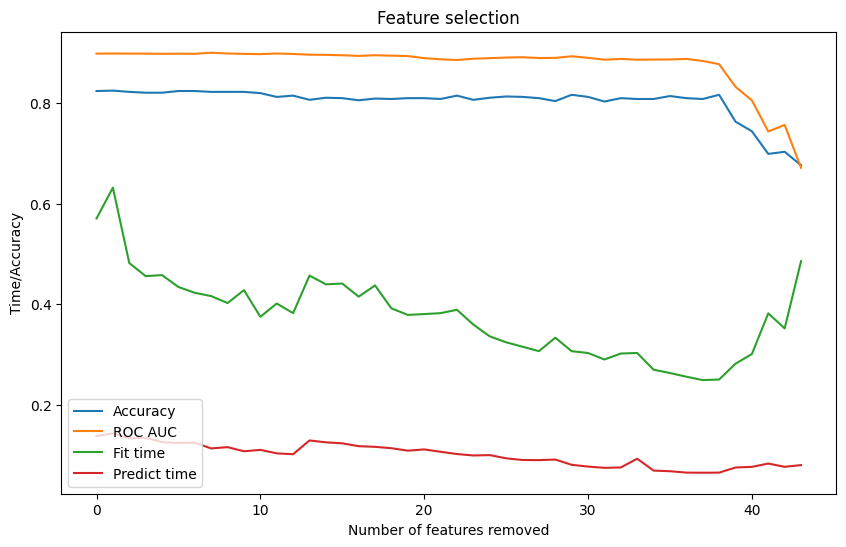

In [49]:
#Show the results
plt.figure(figsize=(10, 6))
plt.plot(range(X.shape[1]), accuracys, label='Accuracy')
plt.plot(range(X.shape[1]), roc_auc_scores, label='ROC AUC')
plt.plot(range(X.shape[1]), fit_times, label='Fit time')
plt.plot(range(X.shape[1]), predict_times, label='Predict time')

#legend bottom left
plt.legend(loc=3)
plt.title('Feature selection')
plt.xlabel('Number of features removed')
plt.ylabel('Time/Accuracy')
plt.show()

## Feature Selection Analysis

Based on the feature selection analysis, we observe the following:

- **Model Stability**: The removal of a significant number of features does not drastically impact the model's accuracy or ROC AUC. This indicates that many of the features may be redundant or not highly informative for the model's performance.
  
- **Computation Time**: As we reduce the number of features, we see a noticeable reduction in both fit time and, to a lesser extent, predict time. This suggests that the model becomes more computationally efficient with fewer features.

## Trade-Off Decision

Given these observations, we are faced with a decision:

- **Accuracy vs. Computation Time**: We can choose to trade off a small amount of accuracy to gain substantial improvements in computation time. This could be particularly beneficial if our model needs to be deployed in a resource-constrained environment or if we require faster training and inference times for large-scale data processing.

### Potential Actions:
1. **Accepting a Minor Accuracy Drop**:
   - We can decide to remove more features, accepting a slight drop in accuracy (as observed in the later stages of feature removal) in exchange for faster computation times. This approach is suitable if the decrease in accuracy is minimal and does not significantly impact the overall model performance.
   
2. **Maintaining Current Accuracy**:
   - Alternatively, we could maintain the current feature set if the accuracy is of paramount importance, especially if we are working in a context where even small gains in accuracy are critical. In this case, we might still benefit from the initial reduction in features, where performance remains stable.

### Conclusion:

- 
